<a href="https://colab.research.google.com/github/kdambrowski/News_recog_soapBeauti/blob/main/Fake_news_detection_from_url_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fake News Classification with download data form URL module 1

## README

This project is diveded by 2 modules:

**Fake_news_detection_from_url_preprocessing which does contains:**
  1. EDA for FakeNewsNet.
  2. Check URL connection for extract articles
  3. Create CSV file from 'active' URL address
  4. Text preprocessing
  5. Extract file to second module where there will be modeling


**Fake_news_detection_from_url_modeling which does contains:**
 1. Modeling
 2. Tune results
 3. Visualizations

**Goal of this project**
1. Preapare DEEP LEARNING MODEL to predict whteter article is FAKE or NEWS

 **SUGGESTIONS**
 1. This code is very time consuming due to URL chek code. Due this fact please used prepared files which do contain in path [Here](https://drive.google.com/drive/folders/12F3tfmnvzquZBHipzskBXitFookz5AnO?usp=share_link)

## FakeNewsNet



About Dataset:

This dataset contains news URL where is possible to download article to predict value.

Original: FakeNewsNet.

Context
All data is got from FakeNewsNet.
The data was extracted form provided URL in FakeNewsNet dataframe.
Modeling and prediction is provided in module 2

#PiP installation

In [1]:
! pip install -q kaggle

In [2]:
!pip install validators -q

  Preparing metadata (setup.py) ... done


In [3]:
!pip install -q neattext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 kB 3.7 MB/s eta 0:00:00


In [4]:
!pip install -q contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 12.2 MB/s eta 0:00:00


# DS's download

To download DS's from kaggle do you will need kaggle access token.
There you have a instruction how to do this
[Kaggle_DS's_download_instruction](https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/)

## Create dictionary in root and copy file with kaggle acconut token to created dictionary

In [5]:
! mkdir ~/.kaggle
""" There you have my own kaggle token.
If you want to download data you have to provide path to your file with kaggles token"""
! cp /content/drive/MyDrive/Colab_Notebooks/Upskill/News_classyfication/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

## Using kaggle API to download DS's to colab enviroment

In [6]:
!kaggle datasets download -d algord/fake-news

  0% 0.00/1.68M [00:00<?, ?B/s]
100% 1.68M/1.68M [00:00<00:00, 169MB/s]


## Unzip files

In [7]:
! unzip /content/fake-news.zip

Archive:  /content/fake-news.zip
  inflating: FakeNewsNet.csv         


# Library

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import csv
import pandas as pd
from spacy import displacy
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from bs4 import BeautifulSoup
import contractions
import os
from imblearn.combine import SMOTEENN
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
import requests
import urllib.request
import pandas as pd
import scipy.stats as stats
from urllib.parse import urlparse
import concurrent.futures
import neattext as nt
import neattext.functions as nfx
import contractions

# Classes and functions

In [9]:
def text_low_standarization(ds):
    ds = ds.applymap(lambda x: x.lower() if isinstance(x, str) else x)
    return ds

def min_column_len_filter(ds, col, len):
  len_filter = ds[col].str.len()>len
  ds = ds[len_filter]
  return ds

def is_null_filter(ds):
  is_null_filter = ds.isnull().sum(axis=1).astype(bool)
  return is_null_filter

def ds_wo_null(ds):
  filter = is_null_filter(ds)
  ds= ds[~filter]
  return ds

def result_m(ds, text_column_name, nfx, list_of_nfx_methods):
    for stuff in dir(nfx):
      for method in list_of_nfx_methods:
        if stuff == method:
          ds[[text_column_name]] = ds[[text_column_name]].apply(stuff)
    return ds

def display_class_pie_distribution(ds, label_col_name):
    class_names = {0: 'FAKE', 1: 'NEWS'}
    class_counts = ds[label_col_name].value_counts(normalize=True).to_dict()
    class_labels = [class_names[k] for k in class_counts.keys()]
    plt.pie(class_counts.values(),
            labels=class_labels,
            autopct='%1.2f%%')
    plt.title(f'{label_col_name} distribution')
    plt.show()

def url_checker(url):
	try:
		get = requests.get(url)
		if get.status_code == 200:
			return(f"{url}: is reachable")
		else:
			return(f"{url}: is Not reachable, status_code: {get.status_code}")

	except requests.exceptions.RequestException as e:
		raise SystemExit(f"{url}: is Not reachable \nErr: {e}")

def update_url(url):
  parsed_url = urlparse(url)
  if not parsed_url.scheme:
      parsed_url = parsed_url._replace(scheme='http')
  if not parsed_url.netloc:
      return None
  if not parsed_url.path:
      parsed_url = parsed_url._replace(path='/')
  return parsed_url.geturl()

def url_check(df, url_list, valid, invalid, list_of_valid_index, problem_index):
  for url in url_list:
    try:
      i = df[url_list == url].index.values
      get = requests.get(url)
      if get.status_code == 200:
        valid += 1
        list_of_valid_index.append(i)
      else:
        invalid += 1
    except:
      print(f'On index: {i} \t%%% PROBLEM OCCURRED %%%')
      problem_index.append(i)
      pass

def extract_text_from_url(url, is_real_news):
    try:
        text = requests.get(url).text
        soup = BeautifulSoup(text, 'html5lib')
        p_tag_finder = soup.find_all('p')
        list_of_tags = [p_tag.text for p_tag in p_tag_finder]
        article_from_url = ' '.join(list_of_tags)
        article_from_url = f'[{is_real_news}] {article_from_url}'
    except:
        article_from_url = f'[{is_real_news}] link has been not readable'
    return article_from_url

def process_batch(batch_urls, batch_is_real_news):
    with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:
        batch_articles = list(executor.map(extract_text_from_url, batch_urls, batch_is_real_news))
    return batch_articles

def nfx_filter(ds, text_source, nfx_filter_list):
    ds['clean_text'] = ds[text_source]
    for filter in nfx_filter_list:
        ds['clean_text'] = ds['clean_text'].apply(eval(f'nfx.{filter}'))
    return ds

# Settings and variables

In [31]:
fake_news_net_path = '/content/FakeNewsNet.csv'
""" ALTERNATIVE LINK to download files to private disc
page_up = 'https://drive.google.com/file/d/1fMFGZhT7fQ-7FP5vp0rXoQMC59dzPtQr/view?usp=drive_link'
article_from_up_pages = 'https://drive.google.com/file/d/1FjOYz77v9LVEG3bCA-Z0jh3L7taW0T-0/view?usp=sharing'
"""
page_up = '/content/drive/MyDrive/Colab_Notebooks/Upskill/News_classyfication/url_with_code_200.csv'
article_from_up_pages = '/content/drive/MyDrive/Colab_Notebooks/Upskill/News_classyfication/readed_news_1.pickle'

null_rows_threshold = 0.1
words_len = 10
batch = 1_000
nfx_filter_list = ['remove_accents',
                   'remove_bad_quotes',
                   'remove_btc_address',
                   'remove_currencies',
                   'remove_currency_symbols',
                   'remove_dates',
                   'remove_emails',
                   'remove_emojis',
                   'remove_hashtags',
                   'remove_html_tags',
                   'remove_mastercard_addr',
                   'remove_md5sha',
                   'remove_multiple_spaces',
                   'remove_non_ascii',
                   'remove_numbers',
                   'remove_phone_numbers',
                   'remove_postoffice_box',
                   'remove_puncts',
                   'remove_punctuations',
                   'remove_shortwords',
                   'remove_special_characters',
                   'remove_stopwords',
                   'remove_street_address',
                   'remove_terms_in_bracket',
                   'remove_urls',
                   'remove_userhandles',
                   'remove_visacard_addr',
]

#EDA

In [14]:
fake_news_net = pd.read_csv(fake_news_net_path)
fake_news_net

,title,news_url,source_domain,tweet_num,real
0,Kandi Burruss Explodes Over Rape Accusation on...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,42,1
1,People's Choice Awards 2018: The best red carp...,https://www.today.com/style/see-people-s-choic...,www.today.com,0,1
2,Sophia Bush Sends Sweet Birthday Message to 'O...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,63,1
3,Colombian singer Maluma sparks rumours of inap...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,20,1
4,Gossip Girl 10 Years Later: How Upper East Sid...,https://www.zerchoo.com/entertainment/gossip-g...,www.zerchoo.com,38,1
...,...,...,...,...,...
23191,Pippa Middleton wedding: In case you missed it...,https://www.express.co.uk/news/royal/807049/pi...,www.express.co.uk,52,1
23192,Zayn Malik & Gigi Hadid’s Shocking Split: Why ...,hollywoodlife.com/2018/03/13/zayn-malik-gigi-h...,hollywoodlife.com,7,0
23193,Jessica Chastain Recalls the Moment Her Mother...,http://www.justjared.com/2018/01/17/jessica-ch...,www.justjared.com,26,1
23194,"Tristan Thompson Feels ""Dumped"" After Khloé Ka...",www.intouchweekly.com/posts/tristan-thompson-f...,www.intouchweekly.com,24,0


In [15]:
fake_news_net = fake_news_net.rename(columns = {'real': 'is_real_news'})

In [16]:
fake_news_net.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23196 entries, 0 to 23195
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   title          23196 non-null  object
 1   news_url       22866 non-null  object
 2   source_domain  22866 non-null  object
 3   tweet_num      23196 non-null  int64 
 4   is_real_news   23196 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 906.2+ KB


In [17]:
fake_news_no_null = ds_wo_null(fake_news_net)
fake_news_no_null.isnull().sum()

title            0
news_url         0
source_domain    0
tweet_num        0
is_real_news     0
dtype: int64

In [18]:
fake_news_no_null = fake_news_no_null.reset_index(drop=True)
fake_news_no_null

,title,news_url,source_domain,tweet_num,is_real_news
0,Kandi Burruss Explodes Over Rape Accusation on...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,42,1
1,People's Choice Awards 2018: The best red carp...,https://www.today.com/style/see-people-s-choic...,www.today.com,0,1
2,Sophia Bush Sends Sweet Birthday Message to 'O...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,63,1
3,Colombian singer Maluma sparks rumours of inap...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,20,1
4,Gossip Girl 10 Years Later: How Upper East Sid...,https://www.zerchoo.com/entertainment/gossip-g...,www.zerchoo.com,38,1
...,...,...,...,...,...
22861,Pippa Middleton wedding: In case you missed it...,https://www.express.co.uk/news/royal/807049/pi...,www.express.co.uk,52,1
22862,Zayn Malik & Gigi Hadid’s Shocking Split: Why ...,hollywoodlife.com/2018/03/13/zayn-malik-gigi-h...,hollywoodlife.com,7,0
22863,Jessica Chastain Recalls the Moment Her Mother...,http://www.justjared.com/2018/01/17/jessica-ch...,www.justjared.com,26,1
22864,"Tristan Thompson Feels ""Dumped"" After Khloé Ka...",www.intouchweekly.com/posts/tristan-thompson-f...,www.intouchweekly.com,24,0


In [19]:
fake_news_drop_dupli = fake_news_no_null.drop_duplicates(subset=['news_url'])

In [20]:
fake_news_drop_dupli.is_real_news.value_counts()

1    16550
0     5108
Name: is_real_news, dtype: int64

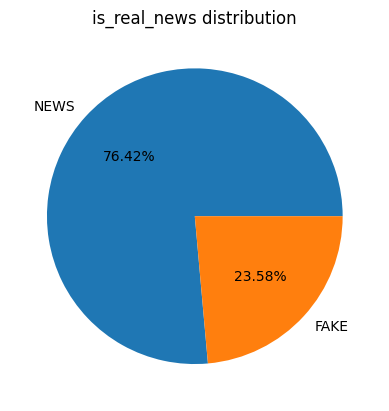

In [21]:
display_class_pie_distribution(fake_news_drop_dupli,'is_real_news')

In [22]:
fake_news_drop_dupli = fake_news_drop_dupli.reset_index(drop = True)

In [23]:
fake_news_drop_dupli

,title,news_url,source_domain,tweet_num,is_real_news
0,Kandi Burruss Explodes Over Rape Accusation on...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,42,1
1,People's Choice Awards 2018: The best red carp...,https://www.today.com/style/see-people-s-choic...,www.today.com,0,1
2,Sophia Bush Sends Sweet Birthday Message to 'O...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,63,1
3,Colombian singer Maluma sparks rumours of inap...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,20,1
4,Gossip Girl 10 Years Later: How Upper East Sid...,https://www.zerchoo.com/entertainment/gossip-g...,www.zerchoo.com,38,1
...,...,...,...,...,...
21653,See 'Love Actually' Sequel Clip for Red Nose D...,https://www.rollingstone.com/movies/movie-news...,www.rollingstone.com,0,1
21654,Pippa Middleton wedding: In case you missed it...,https://www.express.co.uk/news/royal/807049/pi...,www.express.co.uk,52,1
21655,Zayn Malik & Gigi Hadid’s Shocking Split: Why ...,hollywoodlife.com/2018/03/13/zayn-malik-gigi-h...,hollywoodlife.com,7,0
21656,Jessica Chastain Recalls the Moment Her Mother...,http://www.justjared.com/2018/01/17/jessica-ch...,www.justjared.com,26,1


In [24]:
X = fake_news_drop_dupli[['title', 'news_url', 'source_domain']]
y = fake_news_drop_dupli['is_real_news']

for col in X.columns:
    contingency_table = pd.crosstab(y, X[col])
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    if p < 0.05:
      print(f'Feature {col} have impact to predictions')
      print(f'Test chi-kwadrat {col}:')
      print(f'Value of chi2 = {chi2}')
      print(f'P-value = {p}\n')

Feature source_domain have impact to predictions
Test chi-kwadrat source_domain:
Value of chi2 = 9171.018145387472
P-value = 0.0



In [25]:
fake_news_drop_dupli['updated_url'] = fake_news_drop_dupli['news_url'].apply(update_url)

In [26]:
fake_news_drop_dupli

,title,news_url,source_domain,tweet_num,is_real_news,updated_url
0,Kandi Burruss Explodes Over Rape Accusation on...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,42,1,http://toofab.com/2017/05/08/real-housewives-a...
1,People's Choice Awards 2018: The best red carp...,https://www.today.com/style/see-people-s-choic...,www.today.com,0,1,https://www.today.com/style/see-people-s-choic...
2,Sophia Bush Sends Sweet Birthday Message to 'O...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,63,1,https://www.etonline.com/news/220806_sophia_bu...
3,Colombian singer Maluma sparks rumours of inap...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,20,1,https://www.dailymail.co.uk/news/article-33655...
4,Gossip Girl 10 Years Later: How Upper East Sid...,https://www.zerchoo.com/entertainment/gossip-g...,www.zerchoo.com,38,1,https://www.zerchoo.com/entertainment/gossip-g...
...,...,...,...,...,...,...
21653,See 'Love Actually' Sequel Clip for Red Nose D...,https://www.rollingstone.com/movies/movie-news...,www.rollingstone.com,0,1,https://www.rollingstone.com/movies/movie-news...
21654,Pippa Middleton wedding: In case you missed it...,https://www.express.co.uk/news/royal/807049/pi...,www.express.co.uk,52,1,https://www.express.co.uk/news/royal/807049/pi...
21655,Zayn Malik & Gigi Hadid’s Shocking Split: Why ...,hollywoodlife.com/2018/03/13/zayn-malik-gigi-h...,hollywoodlife.com,7,0,None
21656,Jessica Chastain Recalls the Moment Her Mother...,http://www.justjared.com/2018/01/17/jessica-ch...,www.justjared.com,26,1,http://www.justjared.com/2018/01/17/jessica-ch...


# Feature extraction

In [ ]:
""" This code extracts the indexes of URLs where
the HTTP and HTTPS protocols are responding
(i.e., the page is able to load some data).
After checking, the code creates files that include the indexes of these URLs
with the updated URLs.
Suggestion: skip this step for save time, and download
DS prepared ealier by me. File name is "url_with_code_200". """

invalid = 0
valid = 0
list_of_valid_index = []
problem_index = []


for i in range(0, len(fake_news_drop_dupli), batch):
  url_check(fake_news_drop_dupli[i:i+batch],
            fake_news_drop_dupli['updated_url'][i:i+batch],
            valid,
            invalid,
            list_of_valid_index,
            problem_index)

  np.savetxt(f'GFG{i//batch}.csv',
            list_of_valid_index,
            delimiter =", ",
            fmt ='% s')

  """ Checked index is located in the 'page_up' variable,
 where the path to the concatenated CSV is provided.
This code is needed if you don't have CSV files with page status check with name
GFG. These files have been created if has been running above code"""

df_all = pd.DataFrame()
for file in os.listdir():
    if file.startswith('GFG'):
        df_part = pd.read_csv(file, header='infer', names=['index'])
        df_all = pd.concat([df_all, df_part], ignore_index=True)

In [27]:
""" Suggestion if you want to used prepared ds run this code """

with open(page_up, newline='') as f:
    reader = csv.reader(f)
    url_up = [int(r[0]) for r in reader]

In [28]:
""" Creating new DS where pages were response and readable"""

df_up_url = fake_news_drop_dupli.loc[url_up]
df_up_url = ds_wo_null(df_up_url)
df_up_url = df_up_url.reset_index(drop = True)
df_up_url

,title,news_url,source_domain,tweet_num,is_real_news,updated_url
0,Kandi Burruss Explodes Over Rape Accusation on...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,42,1,http://toofab.com/2017/05/08/real-housewives-a...
1,People's Choice Awards 2018: The best red carp...,https://www.today.com/style/see-people-s-choic...,www.today.com,0,1,https://www.today.com/style/see-people-s-choic...
2,Sophia Bush Sends Sweet Birthday Message to 'O...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,63,1,https://www.etonline.com/news/220806_sophia_bu...
3,Colombian singer Maluma sparks rumours of inap...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,20,1,https://www.dailymail.co.uk/news/article-33655...
4,Broward County Sheriff Fired For Lying About P...,https://yournewswire.com/broward-county-sherif...,yournewswire.com,124,0,https://yournewswire.com/broward-county-sherif...
...,...,...,...,...,...,...
13109,Becky G and Boyfriend Sebastian Lletget's Most...,https://people.com/chica/becky-g-sebastian-lle...,people.com,51,1,https://people.com/chica/becky-g-sebastian-lle...
13110,See 'Love Actually' Sequel Clip for Red Nose D...,https://www.rollingstone.com/movies/movie-news...,www.rollingstone.com,0,1,https://www.rollingstone.com/movies/movie-news...
13111,Pippa Middleton wedding: In case you missed it...,https://www.express.co.uk/news/royal/807049/pi...,www.express.co.uk,52,1,https://www.express.co.uk/news/royal/807049/pi...
13112,Jessica Chastain Recalls the Moment Her Mother...,http://www.justjared.com/2018/01/17/jessica-ch...,www.justjared.com,26,1,http://www.justjared.com/2018/01/17/jessica-ch...


In [29]:
X = df_up_url[['title', 'source_domain', 'updated_url']]
y = df_up_url['is_real_news']
for col in X.columns:
    contingency_table = pd.crosstab(y, X[col])
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    if p < 0.05:
      print(f'Feature {col} have impact to predictions')
      print(f'Test chi-kwadrat {col}:')
      print(f'Value of chi2 = {chi2}')
      print(f'P-value = {p}\n')

Feature source_domain have impact to predictions
Test chi-kwadrat source_domain:
Value of chi2 = 8598.85497185167
P-value = 0.0



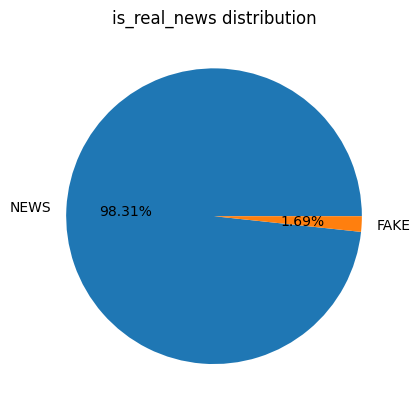

In [30]:
display_class_pie_distribution(df_up_url, 'is_real_news')

In [ ]:
""" This code is time consuming process to save time
I will suggest using prepared DF which is provided in variable
 "article_from_up_pages". For used prepared DF skip this code and run next
 codeline"""

for i in range(0, len(df_up_url), batch):
    batch_urls = df_up_url['updated_url'][i:i+batch]
    batch_is_real_news = df_up_url['is_real_news'][i:i+batch]
    batch_articles = process_batch(batch_urls, batch_is_real_news)
    with open(f'batch_{i//batch}.txt', 'w') as f:
        f.write('###ARTICLE_SEPARATOR###\n'.join(batch_articles))
        f.write('###ARTICLE_SEPARATOR###')

articles = []
is_real_news = []
for filename in os.listdir():
    if filename.startswith('batch_'):
        with open(filename, 'r') as f:
            content = f.read()
            batch_articles = content.split('###ARTICLE_SEPARATOR###')
            batch_articles = [article.strip() for article in batch_articles if article.strip() != '']
            for article in batch_articles:
                is_real_news.append(int(article.split(']')[0].replace('[','')))
                articles.append(article.split('[', 1)[1].strip())
df = pd.DataFrame({'article': articles, 'is_real_news': is_real_news})
df.to_pickle('readed_news_1.pickle')
df['article'] = df['article'].str.replace('\t', '').str.replace('\n', '')

# Preprocessing

In [34]:
df = pd.read_pickle(article_from_up_pages)
df['article'] = df['article'].str.replace('\t', '').str.replace('\n', '')
df_len_check = min_column_len_filter(df, 'article', words_len)
df_len_check['article'] = df_len_check['article'].str.replace(r'(1\]|\b0\])', '', regex=True)
df_len_check

<ipython-input-34-34a59de990bf>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_len_check['article'] = df_len_check['article'].str.replace(r'(1\]|\b0\])', '', regex=True)


,article,is_real_news
0,The star shows his sentimental side with a se...,1
1,Join or Sign In Sign in to customize your TV ...,1
2,.css-1iyvfzb .brand{text-transform:capitalize...,1
3,The couple took to social media to angrily sh...,1
4,By Brianna Wiest Dylan Sprouse and Brenda Son...,1
...,...,...
13108,"""Today is the last day of my marriage to this...",1
13109,Lena Dunham cancelled her planned Lenny tour ...,1
13110,"To revist this article, visit My Profile, the...",1
13112,"By Korin Miller Brie Bella, WWE wrestler and ...",1


In [36]:
df_low = text_low_standarization(df_len_check)
df_low

,article,is_real_news
0,the star shows his sentimental side with a se...,1
1,join or sign in sign in to customize your tv ...,1
2,.css-1iyvfzb .brand{text-transform:capitalize...,1
3,the couple took to social media to angrily sh...,1
4,by brianna wiest dylan sprouse and brenda son...,1
...,...,...
13108,"""today is the last day of my marriage to this...",1
13109,lena dunham cancelled her planned lenny tour ...,1
13110,"to revist this article, visit my profile, the...",1
13112,"by korin miller brie bella, wwe wrestler and ...",1


In [37]:
df_low_clean = nfx_filter(df_low, 'article', nfx_filter_list)
df_low_clean

,article,is_real_news,clean_text
0,the star shows his sentimental side with a se...,1,star shows sentimental secret message embroide...
1,join or sign in sign in to customize your tv ...,1,join sign sign customize listings joining guid...
2,.css-1iyvfzb .brand{text-transform:capitalize...,1,cssiyvfzb brand texttransform capitalize produ...
3,the couple took to social media to angrily sh...,1,couple took social media angrily shut rumors r...
4,by brianna wiest dylan sprouse and brenda son...,1,brianna wiest dylan sprouse brenda song costar...
...,...,...,...
13108,"""today is the last day of my marriage to this...",1,today marriage beautiful forever love hank ope...
13109,lena dunham cancelled her planned lenny tour ...,1,lena dunham cancelled planned lenny tour count...
13110,"to revist this article, visit my profile, the...",1,revist article visit profile view saved storie...
13112,"by korin miller brie bella, wwe wrestler and ...",1,korin miller brie bella wrestler star total di...


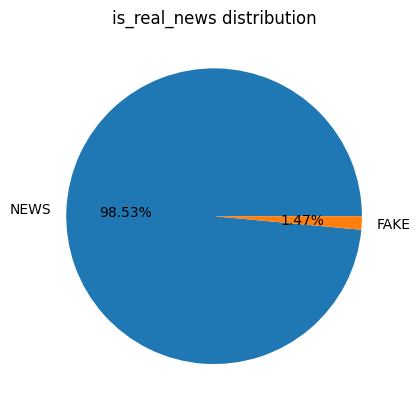

In [38]:
display_class_pie_distribution(df_low_clean, 'is_real_news')

In [ ]:
df_low_clean.to_pickle('after_std_1.pickle')

Modeling, predictions, and visualization are available in module 2. If you want to access this section, click [HERE](https://colab.research.google.com/drive/1mSCVRp3rAlRegSKdqRPTrblh0JVM53uZ?usp=sharing)